# Modulok és Dataprep

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/2019/2019_MAIN_CLEANED.xlsx")

**Minimális Feature Engineering**

In [3]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
for i, row in working_data.iterrows():
    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [4]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 3
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 3]:
        working_data.at[i, "Matematika A1a - Analízis"] = 2

In [5]:
working_data['Matematika A1a - Analízis'].value_counts()

2    145
3     80
1      5
Name: Matematika A1a - Analízis, dtype: int64

**Eszközök és szétbontás**

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = working_data.drop(labels = ["Matematika A1a - Analízis", "Matematika A2c","Kognitív pont", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = working_data["Matematika A1a - Analízis"]
features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [7]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.7542857142857143, 'test_score': 0.7066666666666667}
Params:
{'classifier__n_neighbors': 28, 'classifier__weights': 'distance'}


In [8]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.7314285714285714, 'test_score': 0.6533333333333333}
Params:
{'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


In [9]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 28, 'classifier__weights': 'distance'} 
- Accuracy: 0.7066666666666667
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'} 
- Accuracy: 0.6533333333333333


**SVM**

In [10]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.6914285714285715, 'test_score': 0.6}
Params:
{'classifier__C': 2.9000000000000004, 'classifier__kernel': 'rbf'}

Accuracy: 0.6
Precision: 0.65
Recall: 0.6


**Logisztikus Regresszió**

In [11]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.6342857142857143, 'test_score': 0.5733333333333334}
Params:
{'classifier__C': 0.05, 'classifier__solver': 'sag'}

Accuracy: 0.57
Precision: 0.67
Recall: 0.57


**Naive Bayes**

In [12]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.55


In [13]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.6 
- Logistic Regression: 0.5733333333333334 
- Naive Bayes: 0.55


**Gradient Boosting**

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7314285714285715, 'test_score': 0.6666666666666666}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.25, 'classifier__max_depth': 3, 'classifier__n_estimators': 10}

Accuracy: 0.67
Precision: 0.68
Recall: 0.67


**Lineáris regresszió**

In [15]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.5077267779066184

In [16]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [ 0.11821776  0.10006919  0.64558777  0.91034737  0.75693888 -1.04733785
  0.10709206  0.12418808  0.44865792 -0.05167897 -0.00209615]
RMSE: 0.5


<function matplotlib.pyplot.show(close=None, block=None)>

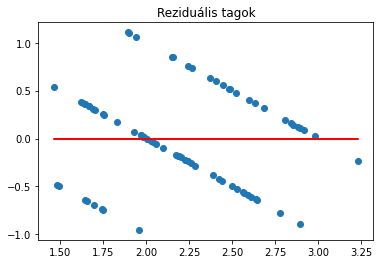

In [17]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [18]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.49

In [19]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.61
0.63


In [20]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.5 
- R2: 0.49 
- RMSE after rounding: 0.61 
- Accuracy after rounding: 0.63


### Eredmények összesítve

In [21]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 28, 'classifier__weights': 'distance'} 
- Accuracy: 0.7066666666666667
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'} 
- Accuracy: 0.6533333333333333
SVM:
- Accuracy: 0.6
Logistic Regression:
- Accuracy: 0.5733333333333334
Naive Bayes:
- Accuracy: 0.55
Linear regression:
- RMSE: 0.5 
- R2: 0.49 
- RMSE after rounding: 0.61 
- Accuracy after rounding: 0.63


# PCA

In [22]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.59, 0.57, 0.6, 0.64, 0.61, 0.61, 0.65, 0.57, 0.56]

In [23]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.57
Precision: 0.53
Recall: 0.68


In [24]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total numbe

In [25]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.6533,0.6533,0.4267,0.5067,0.5382,0.5261,0.6110,0.6267
1,2,0.6667,0.6267,0.5200,0.5867,0.5494,0.5367,0.6218,0.6133
2,3,0.6933,0.6533,0.5467,0.5733,0.5304,0.4972,0.6000,0.6400
3,4,0.6800,0.6133,0.5600,0.5467,0.5334,0.4992,0.5888,0.6533
4,5,0.7067,0.6000,0.5733,0.5333,0.5349,0.5015,0.6000,0.6400
5,6,0.6533,0.6267,0.5467,0.6800,0.5327,0.4955,0.6000,0.6400
6,7,0.6667,0.6267,0.5333,0.6400,0.5371,0.5045,0.6000,0.6400
7,8,0.6400,0.6800,0.5333,0.6267,0.5346,0.5031,0.6000,0.6400


# Modulok és Dataprep

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [27]:
data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/2019/2019_MAIN_CLEANED.xlsx")

**Minimális Feature Engineering**

In [28]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
for i, row in working_data.iterrows():
    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [29]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [3, 4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 1
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 1]:
        working_data.at[i, "Matematika A1a - Analízis"] = 0

In [30]:
working_data['Matematika A1a - Analízis'].value_counts()

1    155
0     75
Name: Matematika A1a - Analízis, dtype: int64

**Eszközök és szétbontás**

In [31]:
from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state = 42, k_neighbors = 4, sampling_strategy = {2: 145, 3: 80, 1: 25})

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = working_data.drop(labels = ["Matematika A1a - Analízis", "Kognitív pont", "Matematika A2c", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = working_data["Matematika A1a - Analízis"]
#features, label = smote.fit_resample(features, label)


X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(


# Osztályozó algoritmusok

**KNN**

In [32]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.7267045454545455, 'test_score': 0.7101449275362319}
Params:
{'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'}


In [33]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.7206439393939394, 'test_score': 0.7246376811594203}
Params:
{'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'}


In [34]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7101449275362319
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7246376811594203


**SVM**

In [35]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.6892045454545455, 'test_score': 0.6521739130434783}
Params:
{'classifier__C': 1.3, 'classifier__kernel': 'linear'}

Accuracy: 0.65
Precision: 0.72
Recall: 0.65


**Logisztikus Regresszió**

In [36]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.7017045454545455, 'test_score': 0.6811594202898551}
Params:
{'classifier__C': 0.8, 'classifier__solver': 'sag'}

Accuracy: 0.68
Precision: 0.75
Recall: 0.68


**Naive Bayes**

In [37]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.74


In [38]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.6521739130434783 
- Logistic Regression: 0.6811594202898551 
- Naive Bayes: 0.74


**Gradient Boosting**

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7388257575757576, 'test_score': 0.6521739130434783}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 40}

Accuracy: 0.65
Precision: 0.6
Recall: 0.65


**Lineáris regresszió**

In [40]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.26184457154592244

In [41]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-8.58999623e-02  1.16009938e-01 -1.63568959e-01 -9.06161839e-01
 -2.95400235e-01  1.61079691e+00 -3.12427622e-03  1.10570042e-01
  1.44276441e-03  2.18015367e-01 -5.87330328e-02]
RMSE: 0.42


<function matplotlib.pyplot.show(close=None, block=None)>

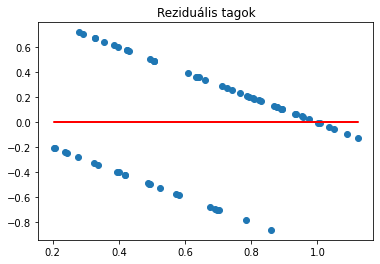

In [42]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [43]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.29

In [44]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.54
0.71


In [45]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.42 
- R2: 0.29 
- RMSE after rounding: 0.54 
- Accuracy after rounding: 0.71


### Eredmények összesítve

In [46]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7101449275362319
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7246376811594203
SVM:
- Accuracy: 0.6521739130434783
Logistic Regression:
- Accuracy: 0.6811594202898551
Naive Bayes:
- Accuracy: 0.74
Linear regression:
- RMSE: 0.42 
- R2: 0.29 
- RMSE after rounding: 0.54 
- Accuracy after rounding: 0.71


# PCA

In [47]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.62, 0.67, 0.68, 0.67, 0.71, 0.67, 0.68, 0.68, 0.68]

In [48]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.74
Precision: 0.73
Recall: 0.72


In [49]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total numbe

In [50]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.5942,0.7101,0.6957,0.7101,0.4436,0.1940,0.5517,0.6957
1,2,0.5942,0.6957,0.6957,0.7246,0.4435,0.1938,0.5517,0.6957
2,3,0.6377,0.7101,0.7246,0.7681,0.4313,0.2044,0.5247,0.7246
3,4,0.5942,0.7101,0.7391,0.6957,0.4305,0.2036,0.5108,0.7391
4,5,0.6667,0.7101,0.7391,0.6667,0.4302,0.2029,0.5247,0.7246
5,6,0.6377,0.6957,0.7391,0.7101,0.4302,0.2033,0.5108,0.7391
6,7,0.6812,0.6812,0.7536,0.7101,0.4307,0.2019,0.5247,0.7246
7,8,0.6812,0.6957,0.7101,0.7391,0.4277,0.2179,0.5247,0.7246


# Legjobb modellek

In [ ]:
# 3 csoport: 5-ös PCA-s Gradboost

# 2 csoport: 4-es PCA-s linreg és logreg (illetvve Naive Bayes) 